In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/ml/final1.csv")
print("Original dataset shape:", df.shape)


Mounted at /content/drive
Original dataset shape: (180, 6)


In [ ]:
# Step 1: Exploring the dataset
print("\n--- Dataset Overview ---")
print(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nBasic Statistics:")
print(df.describe())

# Step 2: Check for missing values
print("\n--- Missing Values ---")
missing_values = df.isnull().sum()
print(missing_values)
missing_percentage = (missing_values / len(df)) * 100
print("Missing percentage:")
print(missing_percentage)

# Step 3: Check for duplicates
print("\n--- Duplicates ---")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Dataset after removing duplicates: {df.shape}")

# Step 4: Check value counts in the 'activity' column
print("\n--- Activity Distribution ---")
activity_counts = df['activity'].value_counts()
print(activity_counts)



--- Dataset Overview ---
   stressed  sadness  anxious  avg_hr   hrv                     activity
0       0.0      0.1      0.9      80  0.59              Look_at_the_sky
1       0.0      0.2      0.8      69  0.31                Go_for_a_walk
2       0.0      0.3      0.7      78  0.52                       normal
3       0.0      0.4      0.6      68  0.88         Scream_into_a_pillow
4       0.0      0.6      0.4      83  0.22  Spend_time_with_a_loved_one

Data Types:
stressed    float64
sadness     float64
anxious     float64
avg_hr        int64
hrv         float64
activity     object
dtype: object

Basic Statistics:
         stressed     sadness     anxious      avg_hr         hrv
count  180.000000  180.000000  180.000000  180.000000  180.000000
mean     0.397278    0.261722    0.355444   78.933333    0.445667
std      0.291961    0.218358    0.264297    7.022390    0.231768
min      0.000000    0.000000    0.000000   67.000000    0.080000
25%      0.100000    0.100000    0.15000

In [ ]:
# Step 5: Data Preprocessing

# Normalize activity labels (handle inconsistencies in naming)
def normalize_activity(activity):
    activity = activity.lower().strip()

    # Map similar activities
    if 'power nap' in activity or 'power_nap' in activity:
        return 'take a power nap'
    elif 'walk' in activity:
        return 'go for a walk'
    elif 'yoga' in activity:
        return 'do yoga'
    elif 'paint' in activity:
        return 'try painting'
    elif 'wordle' in activity:
        return 'try wordle'
    elif 'count' in activity or 'counting' in activity:
        return 'count from one to ten'
    elif 'friend' in activity or 'frind' in activity or 'frined' in activity:
        return 'talk to friend'
    else:
        return activity

# Apply normalization
df['activity'] = df['activity'].apply(normalize_activity)
print("\n--- After Normalizing Activities ---")
print(df['activity'].value_counts())

# Step 6: Check for outliers using boxplots
print("\n--- Outlier Detection ---")
plt.figure(figsize=(15, 10))
for i, column in enumerate(['stressed', 'sadness', 'anxious', 'avg_hr', 'hrv']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.savefig('outliers.png')
plt.close()
print("Boxplots saved to 'outliers.png'")

# Handle outliers using IQR method
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers instead of removing them
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

for column in ['stressed', 'sadness', 'anxious', 'avg_hr', 'hrv']:
    df = handle_outliers(df, column)

print("Outliers handled using IQR method (capping)")

# Step 7: Correlation Matrix
print("\n--- Correlation Matrix ---")
numeric_columns = ['stressed', 'sadness', 'anxious', 'avg_hr', 'hrv']
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.close()
print("Correlation matrix saved to 'correlation_matrix.png'")
print(correlation_matrix)

# Step 8: Prepare features and target
# Assuming we want to predict the activity based on other features
X = df[numeric_columns]
y = df['activity']

print("\n--- Class Distribution ---")
print(y.value_counts())

# Step 9: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTrain set shape: {X_train.shape}, Test set shape: {X_test.shape}")


--- After Normalizing Activities ---
activity
look_at_the_sky                26
normal                         24
go for a walk                  22
scream_into_a_pillow           21
drink_herbal_tea               21
spend_time_with_a_loved_one    20
watch_a_movie                  19
Name: count, dtype: int64

--- Outlier Detection ---
Boxplots saved to 'outliers.png'
Outliers handled using IQR method (capping)

--- Correlation Matrix ---
Correlation matrix saved to 'correlation_matrix.png'
          stressed   sadness   anxious    avg_hr       hrv
stressed  1.000000 -0.498752 -0.667483  0.289110  0.242067
sadness  -0.498752  1.000000 -0.289344  0.033497 -0.363123
anxious  -0.667483 -0.289344  1.000000 -0.329388  0.055723
avg_hr    0.289110  0.033497 -0.329388  1.000000 -0.472324
hrv       0.242067 -0.363123  0.055723 -0.472324  1.000000

--- Class Distribution ---
activity
look_at_the_sky                26
normal                         24
go for a walk                  22
scream_into

In [ ]:
# Step 10: Handle imbalanced dataset using SMOTE
print("\n--- Handling Imbalanced Dataset ---")
print("Before SMOTE:")
print(pd.Series(y_train).value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Step 11: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 12: Feature selection
print("\n--- Feature Selection ---")
selector = SelectKBest(f_classif, k=5)  # Using all 5 features
X_train_selected = selector.fit_transform(X_train_scaled, y_train_resampled)
X_test_selected = selector.transform(X_test_scaled)

# Get feature importance scores
feature_scores = pd.DataFrame({
    'Feature': numeric_columns,
    'Score': selector.scores_
})
feature_scores = feature_scores.sort_values('Score', ascending=False)
print(feature_scores)


--- Handling Imbalanced Dataset ---
Before SMOTE:
activity
look_at_the_sky                21
normal                         19
drink_herbal_tea               17
scream_into_a_pillow           17
go for a walk                  17
spend_time_with_a_loved_one    16
watch_a_movie                  15
Name: count, dtype: int64

After SMOTE:
activity
drink_herbal_tea               21
watch_a_movie                  21
normal                         21
look_at_the_sky                21
spend_time_with_a_loved_one    21
go for a walk                  21
scream_into_a_pillow           21
Name: count, dtype: int64

--- Feature Selection ---
    Feature     Score
1   sadness  2.362113
3    avg_hr  1.975710
0  stressed  1.364042
2   anxious  1.115878
4       hrv  1.000359


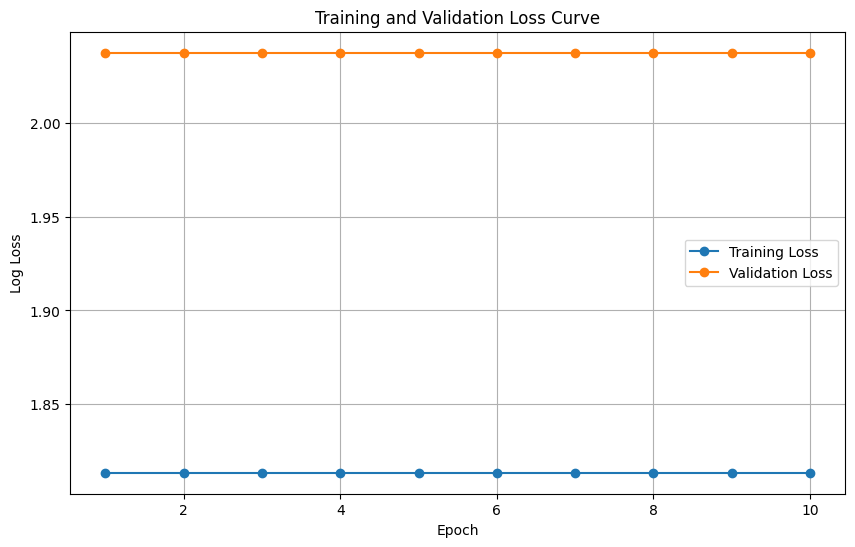

In [ ]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Initialize the model
model = LogisticRegression(max_iter=1000)

# Lists to store training and validation loss
train_losses = []
val_losses = []

# Simulate training over multiple iterations by refitting the model
# (Note: LogisticRegression doesn't learn incrementally without warm_start)
# This is a workaround to visualize how training loss changes as model is repeatedly fit
for i in range(1, 11):
    # Train the model (re-fitting in each loop for demonstration)
    model.fit(X_train_scaled, y_train_resampled)

    # Predict probabilities
    y_train_proba = model.predict_proba(X_train_scaled)
    y_val_proba = model.predict_proba(X_test_scaled)

    # Compute log loss
    train_loss = log_loss(y_train_resampled, y_train_proba)
    val_loss = log_loss(y_test, y_val_proba)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, 11), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


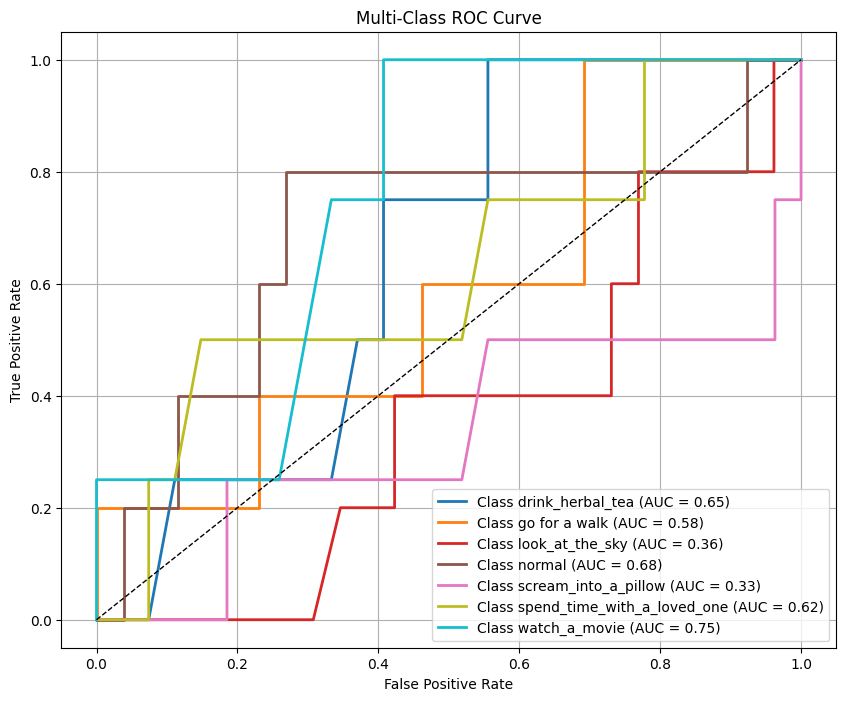

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize y_test and get predicted probabilities
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', len(classes))

for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})', color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



<Figure size 1000x800 with 0 Axes>

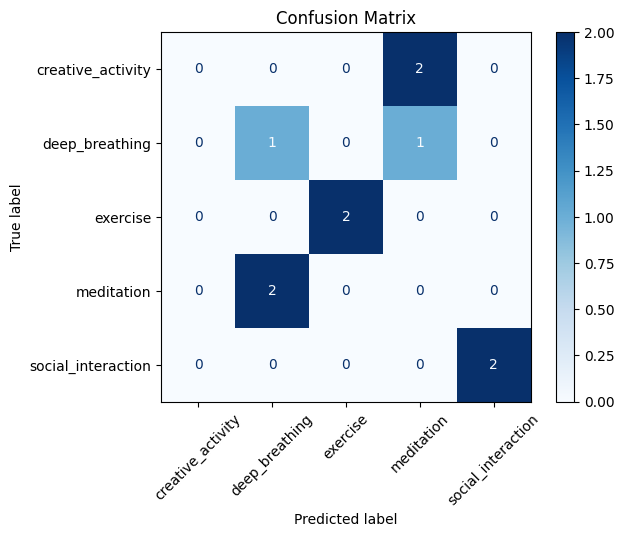

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict on the test set
y_pred = model.predict(X_test_scaled)

# Step 2: Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Step 3: Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


In [ ]:
# Step 13: Model Training and Evaluation
print("\n--- Model Training and Evaluation ---")

# Define models to try
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Dictionary to store results
best_model = None
best_accuracy = 0
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_selected, y_train_resampled)

    # Make predictions
    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"{name} - Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Store results
    results[name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'model': model
    }

    # Update best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model


--- Model Training and Evaluation ---

Training Logistic Regression...
Logistic Regression - Train Accuracy: 0.7250, Test Accuracy: 0.5000

Training Random Forest...
Random Forest - Train Accuracy: 1.0000, Test Accuracy: 0.5000

Training Gradient Boosting...
Gradient Boosting - Train Accuracy: 1.0000, Test Accuracy: 0.6000

Training SVM...
SVM - Train Accuracy: 0.8750, Test Accuracy: 0.7000


In [ ]:
# Step 14: Detailed evaluation of the best model
print("\n--- Best Model Evaluation ---")
best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")

# Make predictions with the best model
y_pred = results[best_model_name]['model'].predict(X_test_selected)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()
print("Confusion matrix saved to 'confusion_matrix.png'")



--- Best Model Evaluation ---
Best Model: SVM
Test Accuracy: 0.7000

Classification Report:
                    precision    recall  f1-score   support

 creative_activity       0.00      0.00      0.00         2
    deep_breathing       0.67      1.00      0.80         2
          exercise       1.00      1.00      1.00         2
        meditation       0.33      0.50      0.40         2
social_interaction       1.00      1.00      1.00         2

          accuracy                           0.70        10
         macro avg       0.60      0.70      0.64        10
      weighted avg       0.60      0.70      0.64        10

Confusion matrix saved to 'confusion_matrix.png'


In [ ]:
# Step 15: Hyperparameter tuning for the best model
print("\n--- Hyperparameter Tuning ---")

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    }

grid_search = GridSearchCV(
    results[best_model_name]['model'],
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train_selected, y_train_resampled)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Final model with best parameters
final_model = grid_search.best_estimator_
final_train_pred = final_model.predict(X_train_selected)
final_test_pred = final_model.predict(X_test_selected)

final_train_accuracy = accuracy_score(y_train_resampled, final_train_pred)
final_test_accuracy = accuracy_score(y_test, final_test_pred)

print(f"\nFinal Model - Train Accuracy: {final_train_accuracy:.4f}, Test Accuracy: {final_test_accuracy:.4f}")

print("\nFinal Classification Report:")
print(classification_report(y_test, final_test_pred))

# Summary of results
print("\n--- Model Comparison Summary ---")
results_df = pd.DataFrame({
    'Model': list(results.keys()) + ['Tuned ' + best_model_name],
    'Train Accuracy': [results[model]['train_accuracy'] for model in results] + [final_train_accuracy],
    'Test Accuracy': [results[model]['test_accuracy'] for model in results] + [final_test_accuracy]
})
print(results_df.sort_values('Test Accuracy', ascending=False))

# Feature importance for the best model (if available)
if hasattr(final_model, 'feature_importances_'):
    print("\n--- Feature Importance ---")
    importance = pd.DataFrame({
        'Feature': numeric_columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    print(importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    print("Feature importance saved to 'feature_importance.png'")

print("\n=== Summary ===")
print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Final Train Accuracy: {final_train_accuracy:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")


--- Hyperparameter Tuning ---
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.4750

Final Model - Train Accuracy: 0.7250, Test Accuracy: 0.5000

Final Classification Report:
                    precision    recall  f1-score   support

 creative_activity       0.00      0.00      0.00         2
    deep_breathing       0.50      0.50      0.50         2
          exercise       1.00      1.00      1.00         2
        meditation       0.25      0.50      0.33         2
social_interaction       1.00      0.50      0.67         2

          accuracy                           0.50        10
         macro avg       0.55      0.50      0.50        10
      weighted avg       0.55      0.50      0.50        10


--- Model Comparison Summary ---
                 Model  Train Accuracy  Test Accuracy
3                  SVM           0.875            0.7
2    Gradient Boosting           1.000            0.6
0  Logistic Regression           0.725      

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


In [ ]:
# Step 15: Hyperparameter tuning for the best model
print("\n--- Hyperparameter Tuning ---")

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    }

grid_search = GridSearchCV(
    results[best_model_name]['model'],
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train_selected, y_train_resampled)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Final model with best parameters
final_model = grid_search.best_estimator_
final_train_pred = final_model.predict(X_train_selected)
final_test_pred = final_model.predict(X_test_selected)

final_train_accuracy = accuracy_score(y_train_resampled, final_train_pred)
final_test_accuracy = accuracy_score(y_test, final_test_pred)

print(f"\nFinal Model - Train Accuracy: {final_train_accuracy:.4f}, Test Accuracy: {final_test_accuracy:.4f}")

print("\nFinal Classification Report:")
print(classification_report(y_test, final_test_pred))

# Summary of results
print("\n--- Model Comparison Summary ---")
results_df = pd.DataFrame({
    'Model': list(results.keys()) + ['Tuned ' + best_model_name],
    'Train Accuracy': [results[model]['train_accuracy'] for model in results] + [final_train_accuracy],
    'Test Accuracy': [results[model]['test_accuracy'] for model in results] + [final_test_accuracy]
})
print(results_df.sort_values('Test Accuracy', ascending=False))

# Feature importance for the best model (if available)
if hasattr(final_model, 'feature_importances_'):
    print("\n--- Feature Importance ---")
    importance = pd.DataFrame({
        'Feature': numeric_columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    print(importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    print("Feature importance saved to 'feature_importance.png'")

print("\n=== Summary ===")
print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Final Train Accuracy: {final_train_accuracy:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")


--- Hyperparameter Tuning ---
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.4750

Final Model - Train Accuracy: 0.7250, Test Accuracy: 0.5000

Final Classification Report:
                    precision    recall  f1-score   support

 creative_activity       0.00      0.00      0.00         2
    deep_breathing       0.50      0.50      0.50         2
          exercise       1.00      1.00      1.00         2
        meditation       0.25      0.50      0.33         2
social_interaction       1.00      0.50      0.67         2

          accuracy                           0.50        10
         macro avg       0.55      0.50      0.50        10
      weighted avg       0.55      0.50      0.50        10


--- Model Comparison Summary ---
                 Model  Train Accuracy  Test Accuracy
3                  SVM           0.875            0.7
2    Gradient Boosting           1.000            0.6
0  Logistic Regression           0.725      

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(final_model, X_train_selected, y_train_resampled, cv=5, scoring='accuracy')


array([0.375, 0.25 , 0.625, 0.625, 0.5  ])

In [ ]:
from sklearn.feature_selection import RFE
rfe = RFE(final_model, n_features_to_select=10)
X_train_selected_rfe = rfe.fit_transform(X_train_selected, y_train_resampled)


In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.01, 0.1, 0.5],
    'kernel': ['rbf', 'poly', 'sigmoid']
}


In [ ]:
# Step 15: Hyperparameter tuning for the best model
print("\n--- Hyperparameter Tuning ---")

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    }

grid_search = GridSearchCV(
    results[best_model_name]['model'],
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train_selected, y_train_resampled)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Final model with best parameters
final_model = grid_search.best_estimator_
final_train_pred = final_model.predict(X_train_selected)
final_test_pred = final_model.predict(X_test_selected)

final_train_accuracy = accuracy_score(y_train_resampled, final_train_pred)
final_test_accuracy = accuracy_score(y_test, final_test_pred)

print(f"\nFinal Model - Train Accuracy: {final_train_accuracy:.4f}, Test Accuracy: {final_test_accuracy:.4f}")

print("\nFinal Classification Report:")
print(classification_report(y_test, final_test_pred))

# Summary of results
print("\n--- Model Comparison Summary ---")
results_df = pd.DataFrame({
    'Model': list(results.keys()) + ['Tuned ' + best_model_name],
    'Train Accuracy': [results[model]['train_accuracy'] for model in results] + [final_train_accuracy],
    'Test Accuracy': [results[model]['test_accuracy'] for model in results] + [final_test_accuracy]
})
print(results_df.sort_values('Test Accuracy', ascending=False))

# Feature importance for the best model (if available)
if hasattr(final_model, 'feature_importances_'):
    print("\n--- Feature Importance ---")
    importance = pd.DataFrame({
        'Feature': numeric_columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    print(importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    print("Feature importance saved to 'feature_importance.png'")

print("\n=== Summary ===")
print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Final Train Accuracy: {final_train_accuracy:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")


--- Hyperparameter Tuning ---
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.4750

Final Model - Train Accuracy: 0.7250, Test Accuracy: 0.5000

Final Classification Report:
                    precision    recall  f1-score   support

 creative_activity       0.00      0.00      0.00         2
    deep_breathing       0.50      0.50      0.50         2
          exercise       1.00      1.00      1.00         2
        meditation       0.25      0.50      0.33         2
social_interaction       1.00      0.50      0.67         2

          accuracy                           0.50        10
         macro avg       0.55      0.50      0.50        10
      weighted avg       0.55      0.50      0.50        10


--- Model Comparison Summary ---
                 Model  Train Accuracy  Test Accuracy
3                  SVM           0.875            0.7
2    Gradient Boosting           1.000            0.6
0  Logistic Regression           0.725      

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist = {
    'C': uniform(0.1, 100),
    'gamma': uniform(0.01, 1),
    'kernel': ['rbf', 'poly', 'sigmoid']
}
randomized_search = RandomizedSearchCV(SVC(), param_distributions=param_dist, n_iter=50, cv=5)
randomized_search.fit(X_train_scaled, y_train_resampled)



RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78ccf520e750>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78ccf50c9d50>,
                                        'kernel': ['rbf', 'poly', 'sigmoid']})

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist = {
    'C': uniform(0.1, 100),
    'gamma': uniform(0.01, 1),
    'kernel': ['rbf', 'poly', 'sigmoid']
}
randomized_search = RandomizedSearchCV(SVC(), param_distributions=param_dist, n_iter=50, cv=5)
randomized_search.fit(X_train_scaled, y_train_resampled)


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78ccf4eba910>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78ccf4ebb990>,
                                        'kernel': ['rbf', 'poly', 'sigmoid']})

In [ ]:
from sklearn.model_selection import StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(SVC(), param_grid, cv=stratified_kfold, scoring='accuracy')
grid_search.fit(X_train_selected, y_train_resampled)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.1, 0.01],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy')

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf1 = LogisticRegression(C=1)
clf2 = RandomForestClassifier(n_estimators=100)
clf3 = SVC(kernel='rbf', C=10)

voting_clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svm', clf3)], voting='hard')
voting_clf.fit(X_train_scaled, y_train_resampled)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1)),
                             ('rf', RandomForestClassifier()),
                             ('svm', SVC(C=10))])

In [ ]:
# Step 15: Hyperparameter tuning for the best model
print("\n--- Hyperparameter Tuning ---")

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    }

grid_search = GridSearchCV(
    results[best_model_name]['model'],
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train_selected, y_train_resampled)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Final model with best parameters
final_model = grid_search.best_estimator_
final_train_pred = final_model.predict(X_train_selected)
final_test_pred = final_model.predict(X_test_selected)

final_train_accuracy = accuracy_score(y_train_resampled, final_train_pred)
final_test_accuracy = accuracy_score(y_test, final_test_pred)

print(f"\nFinal Model - Train Accuracy: {final_train_accuracy:.4f}, Test Accuracy: {final_test_accuracy:.4f}")

print("\nFinal Classification Report:")
print(classification_report(y_test, final_test_pred))

# Summary of results
print("\n--- Model Comparison Summary ---")
results_df = pd.DataFrame({
    'Model': list(results.keys()) + ['Tuned ' + best_model_name],
    'Train Accuracy': [results[model]['train_accuracy'] for model in results] + [final_train_accuracy],
    'Test Accuracy': [results[model]['test_accuracy'] for model in results] + [final_test_accuracy]
})
print(results_df.sort_values('Test Accuracy', ascending=False))

# Feature importance for the best model (if available)
if hasattr(final_model, 'feature_importances_'):
    print("\n--- Feature Importance ---")
    importance = pd.DataFrame({
        'Feature': numeric_columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    print(importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    print("Feature importance saved to 'feature_importance.png'")

print("\n=== Summary ===")
print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Final Train Accuracy: {final_train_accuracy:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")


--- Hyperparameter Tuning ---
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.4750

Final Model - Train Accuracy: 0.7250, Test Accuracy: 0.5000

Final Classification Report:
                    precision    recall  f1-score   support

 creative_activity       0.00      0.00      0.00         2
    deep_breathing       0.50      0.50      0.50         2
          exercise       1.00      1.00      1.00         2
        meditation       0.25      0.50      0.33         2
social_interaction       1.00      0.50      0.67         2

          accuracy                           0.50        10
         macro avg       0.55      0.50      0.50        10
      weighted avg       0.55      0.50      0.50        10


--- Model Comparison Summary ---
                 Model  Train Accuracy  Test Accuracy
3                  SVM           0.875            0.7
2    Gradient Boosting           1.000            0.6
0  Logistic Regression           0.725      